In [279]:
!pip install praw

In [280]:
!pip install config

In [281]:
import re
import praw
import config
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [282]:
matters = ['datascience', 'machinelearning', 'physics', 'astrology', 'conspiracy']

In [283]:
def load_data():

    api_reddit = praw.Reddit(client_id = "bFe2nPTSsj-s7MWC8Jr5Sg", 
    	                     client_secret = "Pkpyhk6VH2uWv1yXbg7fP9VgpPthxQ",
                             #password = "",
                             user_agent = "u/luizbueno82",
                             username = "luizbueno82")

    char_count = lambda post: len(re.sub('\W|\d', '', post.selftext))

    mask = lambda post: char_count(post) >= 100


    data = []
    labels = []


    for i, matter in enumerate(matters):

        subreddit_data = api_reddit.subreddit(matter).new(limit = 1000)


        posts = [post.selftext for post in filter(mask, subreddit_data)]


        data.extend(posts)
        labels.extend([i] * len(posts))

        print(f"Number of subject posts r/{matter}: {len(posts)}",
              f"\nUm dos posts extraídos: {posts[0][:600]}...\n",
              "_" * 80 + '\n')
    
    return data, labels

In [284]:
TEST_SIZE = .2
RANDOM_STATE = 0

In [285]:
def split_data():

    print(f"Split {100 * TEST_SIZE}% dos dados para teste e avaliação do modelo...")
    
    # Split dos dados
    X_train, X_test, y_train, y_test = train_test_split(data, 
                                                            labels, 
                                                            test_size = TEST_SIZE, 
                                                            random_state = RANDOM_STATE)

    print(f"{len(y_test)} amostras de teste.")
    
    return X_train, X_test, y_train, y_test

In [286]:
MIN_DOC_FREQ = 1
N_COMPONENTS = 1000
N_ITER = 30

In [287]:
def preprocessing_pipeline():

    pattern = r'\W|\d|http.*\s+|www.*\s+'
    preprocessor = lambda text: re.sub(pattern, ' ', text)

    vectorizer = TfidfVectorizer(preprocessor = preprocessor, stop_words = 'english', min_df = MIN_DOC_FREQ)

    decomposition = TruncatedSVD(n_components = N_COMPONENTS, n_iter = N_ITER)

    pipeline = [('tfidf', vectorizer), ('svd', decomposition)]

    return pipeline

In [288]:
N_NEIGHBORS = 4
CV = 3

In [289]:
def create_models():

    model_1 = KNeighborsClassifier(n_neighbors = N_NEIGHBORS)
    model_2 = RandomForestClassifier(random_state = RANDOM_STATE)
    model_3 = LogisticRegressionCV(cv = CV, random_state = RANDOM_STATE)

    models = [("KNN", model_1), ("RandomForest", model_2), ("LogReg", model_3)]
    
    return models


In [290]:
def train_avaluate(models, pipeline, X_train, X_test, y_train, y_test):
    
    results = []

    for name, model in models:


        pipe = Pipeline(pipeline + [(name, model)])

        print(f"Training the model {name} with training data...")
        pipe.fit(X_train, y_train)

        y_pred = pipe.predict(X_test)

        report = classification_report(y_test, y_pred)
        print("Relatório de Classificação\n", report)

        results.append([model, {'model': name, 'forecasts': y_pred, 'report': report,}])           

    return results

In [291]:
if __name__ == "__main__":
    

    data, labels = load_data()
    

    X_train, X_test, y_train, y_test = split_data()
    

    pipeline = preprocessing_pipeline()

    all_models = create_models()
    

    results = train_avaluate(all_models, pipeline, X_train, X_test, y_train, y_test)

print("Successfully Concluded!")

Number of subject posts r/datascience: 765 
Um dos posts extraídos: I'm a 3rd year student currently looking to apply for my first internship hopefully next year winter. I am working on a machine learning project, but I'm unsure of how many techniques to use in a single project. Is it enough to use one method only (like pca, svm, neuralnet, etc) for 1 project? How should I try to diversify the languages I use, like R and Python? 

Also if someone could direct me to some good sample ds/ml resumes I would greatly appreciate it....
 ________________________________________________________________________________

Number of subject posts r/machinelearning: 862 
Um dos posts extraídos: Please post your questions here instead of creating a new thread. Encourage others who create new posts for questions to post here instead!

Thread will stay alive until next one so keep posting after the date in the title.

Thanks to everyone for answering questions in the previous thread!...
 ______________

/Users/luizbueno/miniforge3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/luizbueno/miniforge3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

Relatório de Classificação
               precision    recall  f1-score   support

           0       0.84      0.77      0.80       164
           1       0.78      0.88      0.83       164
           2       1.00      1.00      1.00        25
           3       0.91      0.94      0.93       135
           4       0.96      0.83      0.89        83

    accuracy                           0.86       571
   macro avg       0.90      0.88      0.89       571
weighted avg       0.87      0.86      0.86       571

Successfully Concluded!


In [292]:
def plot_distribution():
    _, counts = np.unique(labels, return_counts = True)
    sns.set_theme(style = "whitegrid")
    plt.figure(figsize = (15, 6), dpi = 120)
    plt.title("Número de Posts Por Assunto")
    sns.barplot(x = assuntos, y = counts)
    plt.legend([' '.join([f.title(),f"- {c} posts"]) for f,c in zip(matters, counts)])
    plt.show()

def plot_confusion(result):
    print("Relatório de Classificação\n", result[-1]['report'])
    y_pred = result[-1]['forecasts']
    conf_matrix = confusion_matrix(y_test, y_pred)
    _, test_counts = np.unique(y_test, return_counts = True)
    conf_matrix_percent = conf_matrix / test_counts.transpose() * 100
    plt.figure(figsize = (9,8), dpi = 120)
    plt.title(result[-1]['model'].upper() + " Results")
    plt.xlabel("Valor Real")
    plt.ylabel("Previsão do Modelo")
    ticklabels = [f"r/{sub}" for sub in matters]
    sns.heatmap(data = conf_matrix_percent, xticklabels = ticklabels, yticklabels = ticklabels, annot = True, fmt = '.2f')
    plt.show()

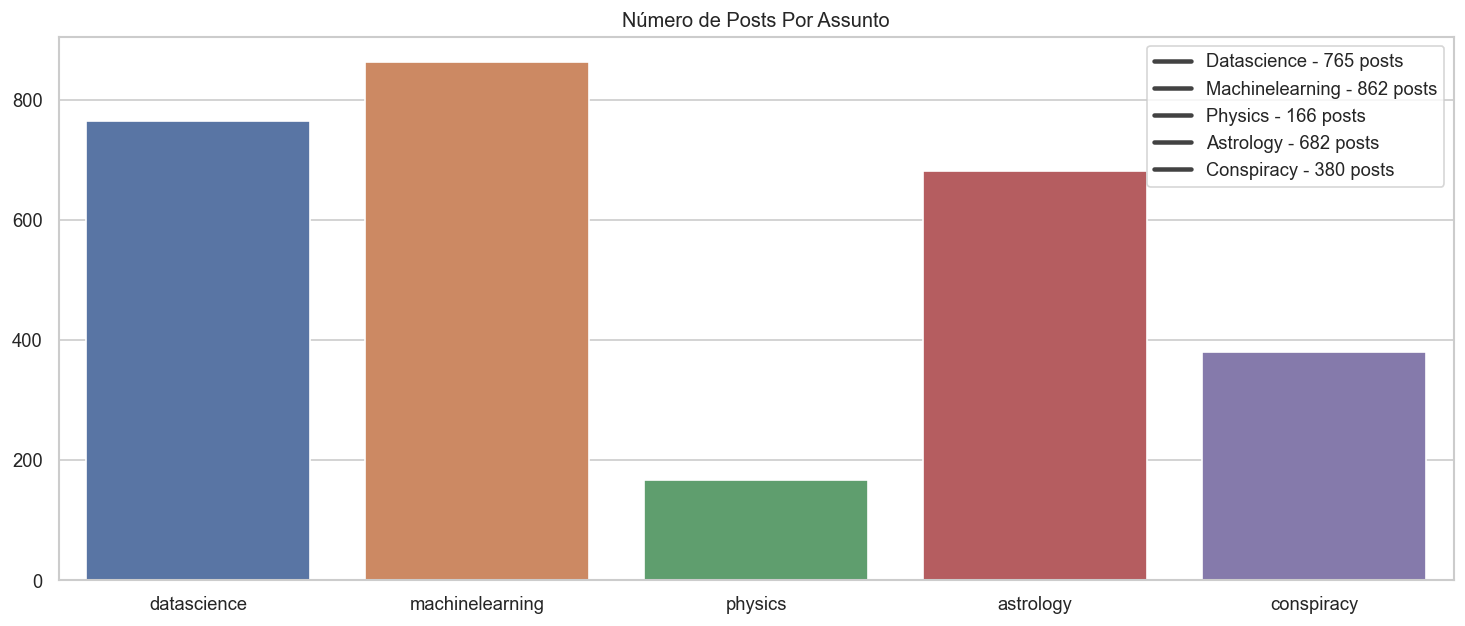

In [293]:
plot_distribution()

Relatório de Classificação
               precision    recall  f1-score   support

           0       0.79      0.66      0.72       164
           1       0.61      0.86      0.71       164
           2       1.00      1.00      1.00        25
           3       0.94      0.90      0.92       135
           4       0.81      0.46      0.58        83

    accuracy                           0.76       571
   macro avg       0.83      0.78      0.79       571
weighted avg       0.78      0.76      0.76       571



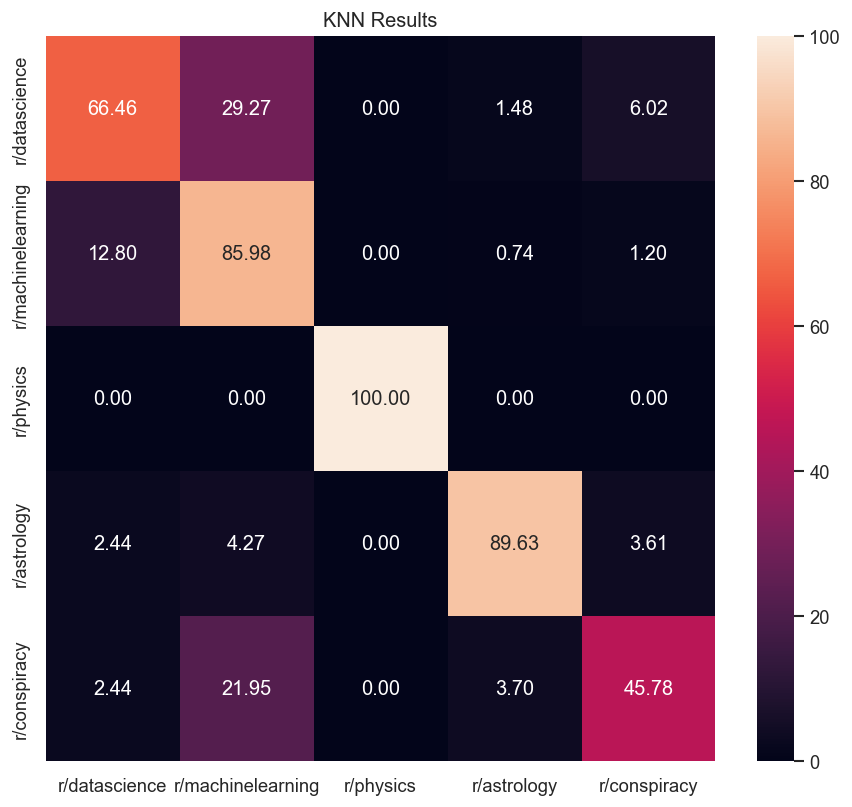

In [294]:
plot_confusion(results[0])

Relatório de Classificação
               precision    recall  f1-score   support

           0       0.79      0.65      0.72       164
           1       0.67      0.88      0.77       164
           2       1.00      1.00      1.00        25
           3       0.94      0.93      0.93       135
           4       0.94      0.71      0.81        83

    accuracy                           0.81       571
   macro avg       0.87      0.83      0.84       571
weighted avg       0.82      0.81      0.81       571



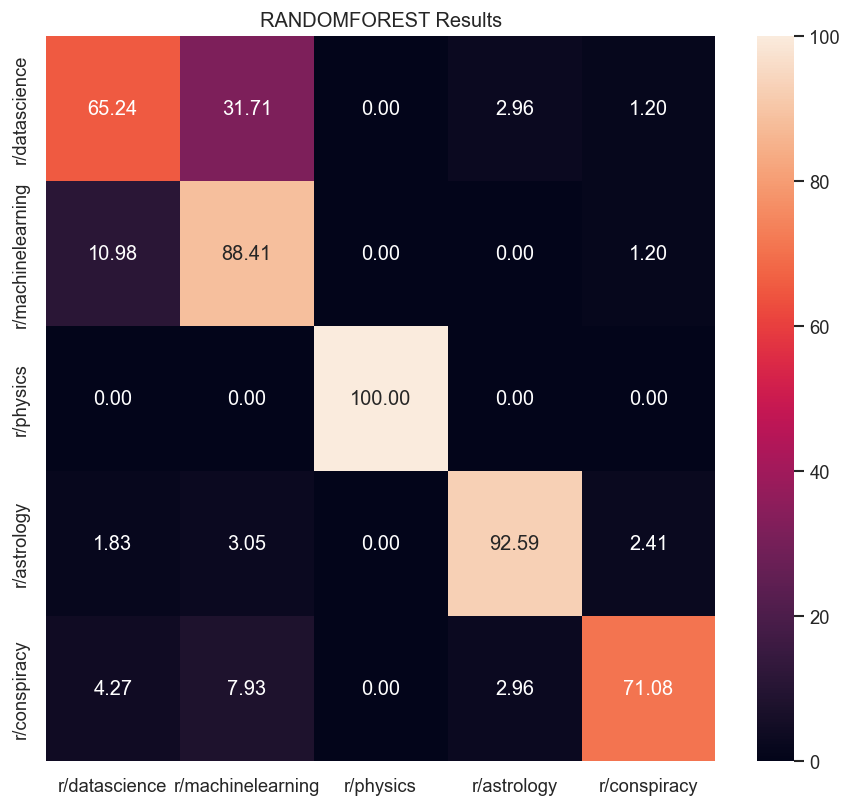

In [295]:
plot_confusion(results[1])

Relatório de Classificação
               precision    recall  f1-score   support

           0       0.84      0.77      0.80       164
           1       0.78      0.88      0.83       164
           2       1.00      1.00      1.00        25
           3       0.91      0.94      0.93       135
           4       0.96      0.83      0.89        83

    accuracy                           0.86       571
   macro avg       0.90      0.88      0.89       571
weighted avg       0.87      0.86      0.86       571



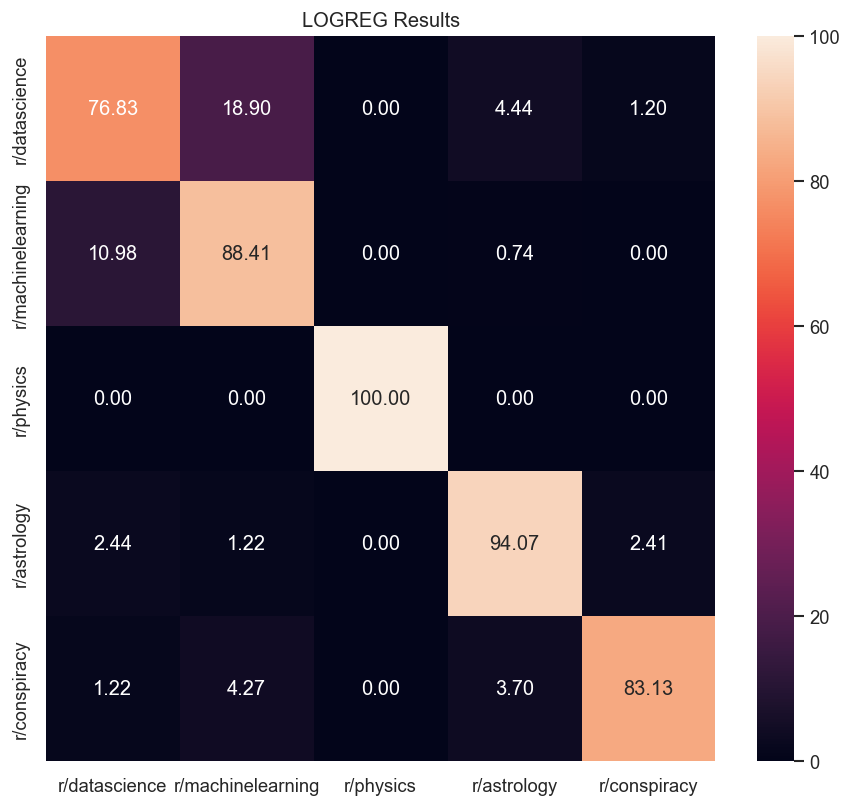

In [296]:
plot_confusion(results[2])